In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using LM-BFGS with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [L^2(0,1)]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|_2^2 + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3},
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameters $\theta$ and $\vartheta$ are non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha(t) = (\beta(t), \gamma(t),m(t)) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, clip, ones, eye, empty, append, diagflat, tril, triu
from numpy           import logical_and, where, allclose, full, clip
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson
from scipy.optimize  import minimize, minimize_scalar, Bounds
from scipy.sparse    import eye as speye
from scipy.interpolate   import interp1d
from scipy.sparse.linalg import LinearOperator
from numpy.polynomial.chebyshev import chebpts1
from matplotlib import colormaps

# Data loading

We load data used in [[1]](https://doi.org/10.1007/978-981-19-7222-5_42) that can be accessed through: [[2]](https://drive.google.com/drive/folders/1w7XzmSNMVff8bUgqgMK2gY5d0a736JF_). Locally, we have stored data of susceptible, active, recovered, and deceased compartments from March 1 – April 30, 2020. The _active_ compartment contains all the different (recorded) infected cases at the time of data recollection. When constructing the dataset, the total population size $\mathsf{n}$ was set to 5\,850\,000 given by an estimate of the UN by mid 2020 [[3]](https://datos.bancomundial.org/indicador/SP.POP.TOTL?end=2023&locations=SG&start=2020). We will set $\mathsf{n}$ to be equal to the total number of people at the initial time.

In [4]:
loaded = np.load('SG_2020_Feb_Apr.npz')

In [5]:
SIRD = loaded['SG']
# Scale population: (helps in computation time)
SIRD *= 1e-4

The data considers reports spanning 60 days. We will group those observations by week and label the initial week by $0$; i.e., $T = 60/7 \approx 63/7 -1 = 8$:

In [6]:
T = SIRD.shape[0]/7.0
#Tᵇᵃˢᵉ = arange(0,T+1)
Tᵒᵇˢ  = linspace(0,T,SIRD.shape[0])

We build a piecewise interpolator for computing any integral terms:

In [7]:
Tₑ = 0.5*(chebpts1(142-2)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])       # Add endpoints
# Add observed points
Tₑ = np.unique(np.sort(concatenate([Tₑ,Tᵒᵇˢ])))

In [8]:
ρ̄ = interp1d(Tᵒᵇˢ,SIRD[:,:-1].T, axis=-1)
ρ̂ = ρ̄(Tₑ)

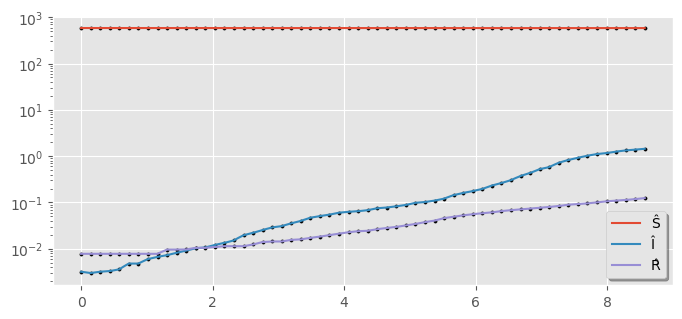

In [9]:
# Plot data
plt.figure(figsize=(8,3.5))

plt.plot(Tₑ,ρ̂.T)
plt.scatter(Tᵒᵇˢ,SIRD[:,0],s=5, c='black')
plt.scatter(Tᵒᵇˢ,SIRD[:,1],s=5, c='black')
plt.scatter(Tᵒᵇˢ,SIRD[:,2],s=5, c='black')

plt.yscale('log')

plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.show()

# Problem setup

In [10]:
# Total population
n = ρ̄(0).sum()
# Initial conditions
ρ̂ₒ = ρ̄(0)
# Final time
ρ̂ᶠ = ρ̄(T)

In [11]:
θ,ϑᵀᵉʳ = 1e-6, 0.1

In [12]:
θ = np.asarray([1e-6,1e-9,1e-9])[::,np.newaxis]

## Differential systems

We define a class in order to quickly get and modify $\alpha$.

In [13]:
class Arg:
    def __init__(self,val=1.0):
        # Check if the input is a scalar or an array-like object
        if np.isscalar(val):
            # If scalar, create an array of ones multiplied by the scalar
            self.data = val * ones([3,Tₑ.size],dtype=float);    self.interp = lambda t: val * asarray([1,1,1]);    self.En = 3 * (val**2) * T
            self.Ens = (val**2) * T * ones([1,3])
        else:
            # If it's not a scalar, attempt to convert it to a numpy array
            self.data = asarray(val)
            # Ensure that the array has the correct shape
            if self.data.shape != (3,Tₑ.size):
                raise ValueError("Wrong input data size.")
            # Add interpolator and compute energy norm
            self.interp = self.sinterp();
            # Compute each norm
            self.En_Norm();            self.En = self.Ens.sum()
        
    # Describe
    def __str__(self):        return f'Function with discrete values stored in {self.data.shape} array.'
    # Print
    def printer(self):        print(self.data);
    # Copy
    def copy(self):           return Arg(self.data.copy())
    # Vectorise
    def ravel(self):          return self.data.ravel()
    # Transpose means: get data
    @property
    def T(self):
        return self.data.T
    
    
    '''
        In-place updates
    '''
    # Set interpolator
    def sinterp(self):                     return interp1d(Tₑ, self.data, axis=-1)
    # Update interpolator
    def uinterp(self):                     self.interp = interp1d(Tₑ, self.data, axis=-1)
    # Compute squared L^2 norm
    def En_Norm(self):                     self.Ens = simpson(self.data**2, x = Tₑ)
    # Updates (adition and set value)
    def add(self, value):              self.data += value;        self.uinterp();        self.En_Norm()
    def update(self,value):            self.data  = value;        self.uinterp();        self.En_Norm()
        
    '''
        Operations
    '''
    # Dot product
    def dot(self,value):
        if isinstance(α, Arg):
            return (self.data * value.data).sum()
        else:
            return (self.data * value).sum()
    # Override the __array__ method to return self.data when treated like an array
    def __array__(self):
        return self.data
    # ** To compute the ℓ_2 norm, just run norm(Arg_instance, ord='fro')    or   (α.data.ravel()**2).sum()**0.5
    
    ''' Creation of new elements from old elements '''
    # Addition: Arg + Arg should return a new Arg instance
    def __add__(self, other):
        if isinstance(other, Arg):
            # Create a new Arg instance with the sum of the data
            new_data = self.data + other.data
            return Arg(new_data)
        else:
            new_data = self.data + other
            return Arg(new_data)

    # Pointwise multiplication: Arg * s should return a new Arg instance
    def __mul__(self, other):
        if isinstance(other, Arg):
            new_data = self.data * other.data
            return Arg(new_data)
        else:
            # Attempt to multiply
            new_data = self.data * other
            return Arg(new_data)

    # Reverse multiplication to support s * Arg
    def __rmul__(self, other):
        return self.__mul__(other)
    
    # Subtraction: Arg - s should return a new Arg instance
    def __sub__(self, other):
        if isinstance(other, Arg):
            new_data = self.data - other.data
            return Arg(new_data)
        else:
            # Attempt to subtract
            new_data = self.data - other
            return Arg(new_data)
    def __rsub__(self, other):
        return self.__sub__(other)

In [14]:
α = Arg(1.0)

In [15]:
print(α)

Function with discrete values stored in (3, 200) array.


Instantiate class with a smooth curve sampled from a Gaussian process:

In [16]:
from sklearn.metrics.pairwise import rbf_kernel
# Adapted a very nice idea from: https://gist.github.com/neubig/e859ef0cc1a63d1c2ea4

In [17]:
Sampled = rng(2024).multivariate_normal( 0.0*Tₑ, rbf_kernel(Tₑ[::,np.newaxis], gamma = 0.25), size = 3 )
Sampled = 0.01 * (0.5 * (Sampled.T - Sampled.min())/np.ptp(Sampled) + 0.25)
# First curve should lie in [0,1e-2]:
if Sampled[:,0].max() > 1e-2:
    Sampled[:,0] *= 1e-2/Sampled[:,0].max()
# Check if m + γ ≤ 1
if Sampled[:,1:].sum(1).max() > 1:
    raise 'Scale (γ,m)'

In [18]:
α = Arg(Sampled.T)

Reproduction number associated with initial guess:

In [19]:
print('Basic reproduction number:', n * α.interp(0)[0]/α.interp(0)[1:].sum())

Basic reproduction number: 190.95285502133996


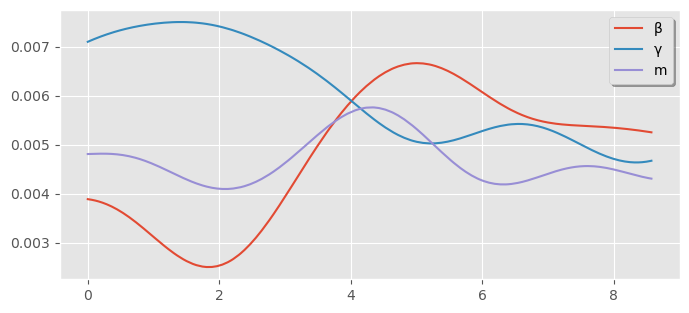

In [20]:
# Plot initial point
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ, α.T)
plt.legend(['β', 'γ', 'm'], shadow=True)
plt.show()

## Solve a state:

In [21]:
def SIRD(t, z,  α_interp):
    β, γ, m = α_interp(t)    # Use interpolator
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [22]:
sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=[α.interp], t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


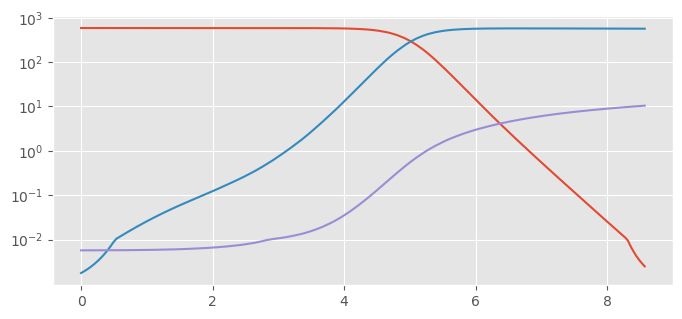

In [23]:
# Plot solution:
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ,sol.y.T)
plt.yscale('symlog', linthresh=1e-2)
#plt.xscale('symlog', linthresh=1e-2)

## Solve its adjoint

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = \vartheta\big[\rho(T) - \widehat{\rho}(T)\big]$.

In [24]:
# Interpolator from ODE
ρₜ = sol.sol
ρ = sol.y

In [25]:
def Adjoint(t, z, α_interp,ρ):
    β, γ, m = α_interp(t)    # Use interpolator
    S̄, Ī, R̄ = ρ̄(t)           # Target
    S, I, R = ρ(t)           # State
    qₛ, qᵢ, qᵣ = z           # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

In [26]:
qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)
solₛ = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
q = solₛ.y[:,::-1]
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 110 function evaluations.


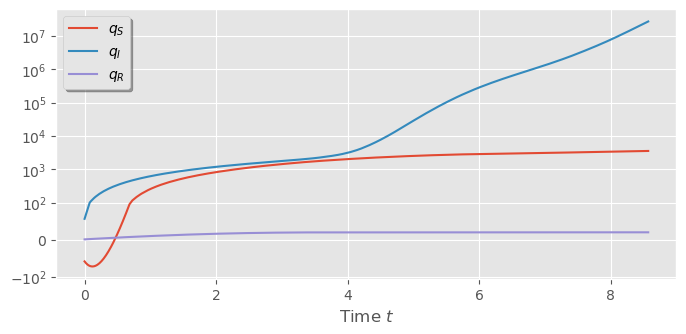

In [27]:
# Plot adjoint curves
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ[::-1],q.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.yscale('log')
plt.yscale('symlog', linthresh=1e+2)
plt.show()

## Cost and gradient

Now we try to optimise the function
\begin{align}
    j(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 + \frac{1}{2} \big( \theta_1 \beta^2(t) + \theta_2 \gamma^2(t) + \theta_3 m^2(t) \big) + H\big(\alpha(t) \big) \,\dif t  + \frac{1}{2} \| \vartheta (\rho(T) - \widehat{\rho}(T)) \|^2_{\R^3}
    .
\end{align}

In [28]:
# Define penalty function and its derivative
H_s  = lambda s: 1e+3 * np.where(s > 0.0, s**2, 0.0)
dH_s = lambda s: 1e+3 * np.where(s > 0.0, 2*s, 0.0)

In [29]:
def Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ):
    # State + controls
    scaling = True
    s  = simpson((ρ-ρ̂)**2, x=Tₑ).sum()  +  (ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)**2).sum()
    s /= (n**2) if scaling else 1.0
    # Controls
    s +=  (α.Ens * θ.T).sum()
    # Weight and add penalty
    return 0.5 * s  +  simpson( H_s( α.data[1,:] + α.data[2,:] - 1.0/7 ), x = Tₑ)

In [30]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format(  Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ) ))

As an example, the distance between ρ and ρ̂ is 3.3213.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &=  S I( q_I - q_S )  + \theta_1 \beta
    \\
    \frac{\partial f}{\partial \gamma} &=  I( q_R - q_I )   + \theta_2 \gamma   + 2\lambda \max\{0, \gamma + m -1 \}
    \\
    \frac{\partial f}{\partial m} &=  -I q_I    + \theta_3 m   + 2\lambda \max\{0, \gamma + m -1 \}
\end{align}

In [31]:
df = asarray([ρ[0]*ρ[1] * (q[1]-q[0]), 
              ρ[1] * (q[2]-q[1]) + n**2*dH_s(α.data[1,:] + α.data[2,:] - 1.0), 
              -ρ[1] * q[1] + n**2*dH_s(α.data[1,:] + α.data[2,:] - 1.0/7) ])/(n**2)  + θ * α.data

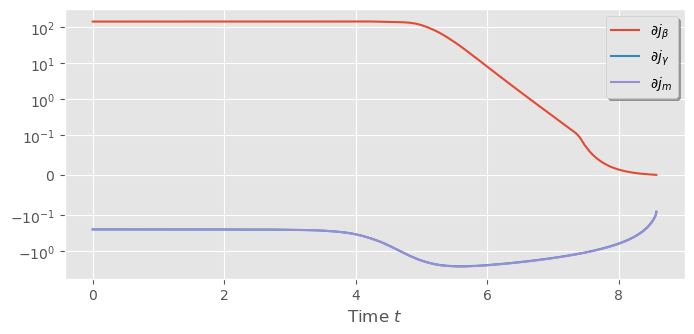

In [32]:
# Plot derivative
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ,df.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$\partial j_β$', '$\partial j_γ$', '$\partial j_m$'], shadow=True)
#plt.yscale('log')
plt.yscale('symlog', linthresh=1e-1)
plt.show()

### Define projection

In [33]:
upper_b = np.asarray([1e-2/7,1.0/7,1.0/7])[::,np.newaxis]

In [34]:
def proj(α):    return Arg(np.clip(α, 0.0, upper_b))

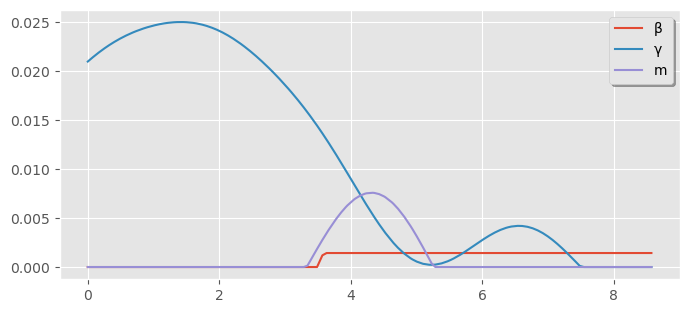

In [35]:
# Test projection
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ, proj( 1e+1*(α-0.005) ).data.T)
plt.legend(['β', 'γ', 'm'], shadow=True)
plt.show()

# A few evaluations

Let us evaluate the objective for some curves:

In [36]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [37]:
def obj_eval_a(α):                # ** Eval just j ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
        
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
        
    ρᵦ = ρ_sol.y
    f = Objective(ρᵦ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    return asarray(f)

def obj_eval(α):                  # ** Eval j and j' ** #
    global ρ, q
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    s = (1.0/(n**2)) if scaling else 1.0
    df = asarray([ s * ρ[0]*ρ[1] * (q[1]-q[0]), 
                   s * ρ[1] * (q[2]-q[1])      + dH_s(α.data[1,:] + α.data[2,:] - 1.0), 
                  -s * ρ[1] * q[1]             + dH_s(α.data[1,:] + α.data[2,:] - 1.0) ])
    df += (θ * α.data)
    
    return asarray(f), df
def obj_eval_d(α):                # ** Does not affect global variables ρ, q ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρᵦ = ρ_sol.y
    f = Objective(ρᵦ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρᵦ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
    qᵦ = q_sol.y[:,::-1]

    # Compute derivative
    s = (1.0/(n**2)) if scaling else 1.0
    dF = asarray([ s * ρᵦ[0]*ρᵦ[1] * (qᵦ[1]-qᵦ[0]), 
                   s * ρᵦ[1] * (qᵦ[2]-qᵦ[1])      + dH_s(α.data[1,:] + α.data[2,:] - 1.0), 
                  -s * ρᵦ[1] * qᵦ[1]              + dH_s(α.data[1,:] + α.data[2,:] - 1.0) ])
    dF += (θ * α.data)
    
    return asarray(f), dF

In [38]:
obj_eval_a(α)

array(3.32124131)

---

In [39]:
Samples = rng(2024).multivariate_normal( 0.0*Tₑ, rbf_kernel(Tₑ[::,np.newaxis], gamma = 0.25), size = (20,3) )
Samples = 0.01 * (0.5 * (np.transpose(Samples, (0, 2, 1)) - Samples.min())/np.ptp(Samples) + 0.25)

In [40]:
#Samples[:,:,0].max() > 1e-2   # returns false
#(Samples[:,:,1:].sum(2) > 1).any()   # same

In [41]:
Misfit = zeros([20,1])
for i in range(20):
    Misfit[i] = obj_eval_a(Arg(Samples[i].T))

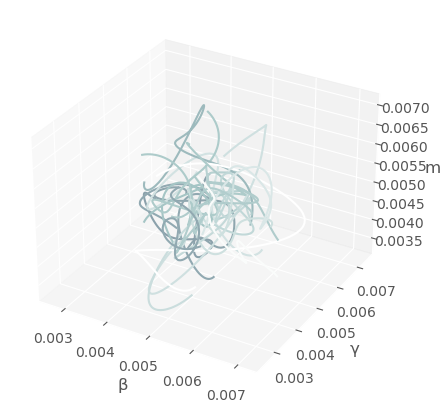

In [42]:
# Coarse sample
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure( figsize=(5, 11) )
ax = fig.add_subplot(111, projection='3d')

# Plot each curve with colors reflecting the Misfit values
for i, curve in enumerate(Samples):
    x = curve[:, 0]  # X coordinates
    y = curve[:, 1]  # Y coordinates
    z = curve[:, 2]  # Z coordinates
    
    # Get the color for the current curve based on the Misfit value
    color = colormaps['bone'](Misfit[i]/Misfit.max())
    
    # Plot the curve in 3D with the corresponding color
    ax.plot(x, y, z, c = color)

# Set labels for the axes
ax.set_xlabel('β')
ax.set_ylabel('γ')
ax.set_zlabel('m')
ax.set_xlim([ max(0, Samples[:,:,0].min()), min(1e-2, Samples[:,:,0].max() ) ])
ax.set_xlim([ max(0, Samples[:,:,1].min()), min(1, Samples[:,:,1].max() ) ])
ax.set_zlim([ max(0, Samples[:,:,2].min()), min(1, Samples[:,:,2].max() ) ])

ax.set_facecolor('xkcd:white')
ax.set_box_aspect((1, 1, 0.75))
# Show the plot
plt.show()

In [43]:
print('Smallest objective found in the sample: {0};'.format(Misfit.min()) )

Smallest objective found in the sample: 3.0723899549375466;


# Solving the optimisation problem

We will use a trust region limited memory algorithm for optimising $f$. In this setting, we will write $x_k$ for the iterates $\alpha_k$.

Following the work of Yuan et al (2014), assuming 0 and $1$ as lower and upper bounds, respectively,
we introduce the quantity $x_k := \min\big\{\beta_k, c \|\nabla f(x_k)\|\big\} $, where $\beta_k$ and $c$ are positive constants such that $ 0 < \beta_k < \frac{1}{2} \min\mathrm{diam} \mathcal{A}_i $, and define the strongly-active and inactive index sets by
\begin{align}
    A_k &:= \big\{ i \in \{1, \dots,n\}: \, x_{k,i} 
            \leq \xi_k \lor x_{k,i} \geq 1 -  \xi_k \big\},	
            \label{ec:active_set}
    \tag{1.a}
    \\
    I_k &:= \{1, \dots,n\} \setminus A_k = 
            \big\{ i \in \{1, \dots,n\}: \, \xi_k < x_{k,i} < 1 -  \xi_k \big\},	\label{ec:inactive_set}
    \tag{1.b}
\end{align}
respectively, where $x_{k,i}$ is the $i$-th element of $x_k$.
Now, suppose the current trust region radius is $\widehat\Delta >0$, with its maximum value $\Delta_{\max} > 0$, and let $\kappa > 0$. We can obtain a search direction at step $x_k$ as follows:

* **Projected gradient direction:** Compute
\begin{equation}\label{ec:proy_grad}
d^G_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{1 , \,x_k - \dfrac{\widehat\Delta}{\Delta_{\max}}  \kappa_k \nabla f(x_k) \right\} \right\} - x_k.
\tag{PG}
\end{equation}

* **Projected trust-region direction:** We look for a direction $d^{\text{tr}}_{*k} (\widehat\Delta)$ defined for each index of the sets $A_k$ and $I_k$, respectively.
We begin with $A_k$, for which we let $v_k^{A_k}$ be the subvector
\begin{equation}
    v_k^{A_k} :=
    \begin{cases}
        x_{k,i}     & \text{if } x_{k,i} \leq \xi_k,  \\
        1 - x_{k,i} & \text{if } x_{k,i} \geq 1 - \xi_{k}.
    \end{cases}
\end{equation}
Then we define the subvector
\begin{equation}
    d^{A_k}_{*k} (\widehat\Delta)  := \min \left\{ 1, \dfrac{\widehat\Delta}{\|v_k^{A_k}\|} \right\} v_k^{A_k}.
    \tag{SV}
\end{equation}
For the inactive set $I_k$ we solve a reduced trust-region subproblem. Here, let $B_k$ be partitioned into two submatrices $B_k^{A_k} $ and $B_k^{I_k} $, obtained by taking columns of $B_k$ indexed by $A_k$ and $I_k$, respectively. Let $ d^{I_k}_{*k} (\widehat\Delta) $ be a solution of the following TR–subproblem
\begin{equation} \label{ec:subvector_inactive}
\begin{aligned}
        \min \;\, & d^\top \Big[ \big(B_k^{I_k}\big)^\top \big( \nabla f(x_k) + B_k^{A_k} d^{A_k}_{*k}  \big) \Big] + \dfrac{1}{2} d^\top \big(B_k^{I_k}\big)^\top B_k^{I_k} d\\
\text{s.t. } & \|d\| \leq \widehat\Delta.
\end{aligned}
\tag{TR}
\end{equation}
The projected trust-region direction is then defined as
\begin{equation}
    d^{\text{tr}}_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{ 1, \, x_k + \begin{pmatrix} d^{A_k}_{*k} (\widehat\Delta) \\ d^{I_k}_{*k} (\widehat\Delta)  \end{pmatrix}\right\} \right\} - x_k.
\end{equation}
Since this direction may not be a descent direction for $f$ for far iterates, we use a convex combination with the gradient direction as follows.

* **Search direction:** Let
\begin{equation}
d_{* k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta),
	\end{equation}
	where $t_{*k}$  is a solution of the following one-dimensional problem
	\begin{equation}\label{ec:search_dir_one_dim}
		\min_{t \in [0,1]} f\big( x_k + t d_{*k}^G(\widehat\Delta) + (1- t) d^{\text{tr}}_{*k} (\widehat\Delta) \big).
        \tag{SD}
	\end{equation}

<div class="alert alert-block alert-warning">
Yuan, G., Wei, Z. & Zhang, M. An active-set projected trust region algorithm for box constrained optimization problems. J Syst Sci Complex 28, 1128–1147 (2015). https://doi.org/10.1007/s11424-014-2199-5
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Trust-Region Algorithm with L-BFGS Update</h2>
<ol>
<li>Choose \(x_0 \) and a symmetric positive definite matrix \(H_0\). Let constants satisfy \(0 < \beta_0 < \frac{1}{2} \min \mathrm{diam}\mathcal{A}_i \), \(c>0\), \(0 < \nu_1 < 1 < \nu_2\), \(0<\tau_1<\tau_2<1\), \(\upsilon \in (0,1)\), \(\omega \in \mathbb{R}^{3\times d}\), \(\Delta_0 >0\), and \( \Delta_{\max} > \Delta_{\min} > 0\). Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\)
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Let \(\Delta_k := \min\big\{ \Delta_{\max}, \max\{\Delta_{\min}, \Delta_k\} \big\}\) and \(\widetilde\Delta = \Delta_k\).
</li>
    
<li> Determine index sets \(A_k\) and \(I_k\) by (1.a) and (1.b).
</li>
    
<li> Find \(d_{*k}^{\text{tr}} (\widetilde\Delta)\) by determining \(d_{*k}^{A_k} (\widetilde\Delta)\) and \(d_{*k}^{I_k} (\widetilde\Delta)\) as in (SV) and (TR).
</li>
    
<li> Set
    \[
        \kappa_k := \min\left\{ 1, \dfrac{\Delta_{\max}}{\big\| \nabla j(x_k) \big\|}, \dfrac{\omega}{\big\| \nabla j(x_k) \big\|} \right\}.
    \]
</li>


<li>Compute \( d_{*k}^G(\widetilde\Delta)\) and \(t_{*k}\) as in (PG) and (SD), respectively. Let
    \[
        d_{*k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta).
    \]
</li>
    
    
<li>Compute
    \[
        r_{*k} := \dfrac{ j(x_k + d_{*k}) - j(x_k)}{ \nabla j(x_k)^\top d_{*k} (\widehat\Delta) + \frac{1}{2} \, d_{*k} (\widehat\Delta)^\top B_k d_{*k} (\widehat\Delta)}
    \]
</li>
    
    
<li> \(\mathbf{If}\) \(j(x_k) - j \big(x_k + d_{*k} (\widehat\Delta) \big) \geq -\upsilon \nabla j (x_k)^\top d^G_{*k} (\widehat\Delta)\) and \(r_{*k} \geq \tau_1\) hold \(\mathbf{then}\)
</li>
    
<ol>
    <li> Let \(q_k := d_{*k}\), \(x_{k+1} := x_k + d_{*k}\), \(\beta_k = \widehat\Delta \), and
        \[
            \Delta_{k+1} :=
            \begin{cases}
                \widehat\Delta & \text{if } \tau_1 < r_{*k} < \tau_2,
                \\
                \nu_2 \widehat\Delta & \text{if } r_{*k} \geq \tau_2.
            \end{cases}
        \]
    </li>
    <li> Let \(\widehat m := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
    <li> Let \(k = k+1\) and return to step A. </li>
</ol>
    

    
<li> \(\mathbf{else}\) </li>
<ol>    
    <li>Let \(\widehat\Delta = \tau_1 \widehat\Delta\). </li>
<li> Return to step C.</li>
</ol>
</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

One aspect of the BFGS method is that each update is positive definite. As the limited memory formula for $B_k$ can also be stated as
\begin{equation}
	B_k = V_k^\top H_k V_k + p_k q_k q_k^\top,
\end{equation}
with $ p_k := \big( q_k^\top d_k \big)^{-1}$ and $V_k :=  I_n - p_k d_k q_k^\top$. Thus, we can guarantee positive definiteness using Powell's method in which $d_k$ is redefined as
\begin{equation}
	d_k :=
	\begin{cases}
		d_k		& \text{if } q_k^\top d_k \geq 0.2 q_k^\top B_k d_k,
		\\
		\alpha_k d_k + (1-\alpha_k) B_k q_k & \text{otherwise},
	\end{cases}
\end{equation}
where $\alpha_k := \frac{0.8 q_k^\top B_k q_k}{q_k^\top B_k q_k - q_k^\top d_k}$. If the updated $q_k^\top d_k$ is too close to zero, to maintain numerical stability, the limited memory matrix is not updated.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

In [44]:
def box_scale(x,y):
    '''
        Return minimum value of scalar s > 0  such that x + sy ∈ [0,1] for x ∈ [0,1]
    '''
    a = np.divide(x, y, where=(y>0))[y>0]
    b = np.divide((x-1), y, where=(y<0))[y<0]
    if len(a) > 0:
        if len(b) > 0:
            return min( a.min(), b.min() )
        else:
            return a.min()
    else:
        return b.min()

In [45]:
def LMBFGS(α, iters=20, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 5e-13, print_tests = False):
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Preamble of functions for limited memory ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    dim = 3 * Tₑ.size            # dimension of the hyperparameter to optimise 
    '''Reserve memory'''
    cLM   = 3
    S     = speye(dim, cLM, format = 'csr').A;                        Y = S.copy()
    SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
    
    # LM routines: forward, adjoint, transpose, and projections to active set data
    def Limited():
        def B_eval(W,MI,dk):
            db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
        def BA_eval(W,MI,Uk,dUk):
            db = zeros(dim, dtype='float')
            db[Uk] = dUk;            db *= θᵪ;        db -= W.dot(MI.dot(W[Uk,:].T.dot(dUk)));     return db
        def BAT_eval(W,MI,Uk,dUk):
            db = dUk[Uk].copy();     db *= θᵪ;        db -= W[Uk,:].dot(MI.T.dot(W.T.dot(dUk)))
            return db
        def H_eval(WH,MH,dk):
            db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
        def HA_eval(WH,MH,Uk,dUk):
            db = zeros(dim, dtype='float');   db[Uk] = dUk;    db /= θᵪ;    db += WH.dot(MH.dot(WH[Uk,:].T.dot(dUk)))
            return db
        def HAT_eval(WH,MH,Uk,dUk):
            db = dUk[Uk].copy();     db /= θᵪ;     db += WH[Uk,:].dot(MH.T.dot(WH.T.dot(dUk)));   return db
        return B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval
    
    # Limited memory functions (two options are available LBFGS or LSR1)
    def LBFGS(S,Y,SY, θ):
        W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
        MI  = inv(MM)
        WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
        MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
        return MI, MH, W, WH
    def LSR1(S,Y,SY, θ):
        W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
        while np.linalg.det(MM) == 0.0:
            # Backtracking
            θ *= 0.5
            W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
            M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
        MI = inv(MM)
        WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
        MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
        return MI, MH, W, WH
    
    Method = 'BFGS'
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Create structures to store information from iterates ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    if save_iter:
        every_iter = {a:[] for a in ['it', 'obj', 'time', 't_k', 'norms']}
        every_iter['norms'] = {a:[] for a in ['ℓ_1', 'ℓ_2', 'max', 'min']}
    else:  every_iter = {}
    
    every_critical = {a:[] for a in ['it', 'obj', 'time', '|df|_2', '|df|_max']}
    best = {'obj': 1e+10, 'α': None, 'df': None}
    

    
    ''' 
        \\\\\\\\\\\\\\\\\\\\\\
        *** Initialisation ***
        \\\\\\\\\\\\\\\\\\\\\\
    '''
    xₖ = α.copy()      # IMPORTANT to avoid clash with the α defined below (!!!)
    

    # All objects involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
    
    ''' Setting TR parameters '''
    αᵪ = [0.5, 2.0]                  # TR scaling factors  0 < αᵪ[0] < 1 < αᵪ[1]
    ρᵪ = [1e-5,0.75]                 # TR acceptance ratio (Success & Increase region)  0 < ρᵪ[0] < ρᵪ[1] < 1
    #ρᵪ = [1e-2,0.5]
    bᵪ = (ones([3,Tₑ.size]) * upper_b).ravel()                         # Box upper bound
    σᵪ = 0.01                        # Armijo–Goldstein parameter for linesearch  0 < σᵪ < 1 (l/2L?) [0.00025]
    ηᵪ = 0.05                         # Normalisation scale for gradient directions  0 < ηᵪ < 1
    δᵪ = 0.99 * 0.5 * upper_b.min()  # Ambiguity threshold for active set estimation  δᵪ < ½ (ℓ-u)  [small>linear]
    cᵪ = 1.5                         # Gradient scaling factor for active set estimation  c > 0  [goes along pᵪ]
    pᵪ = 0.35                        # 0 < pᵪ < 1 [comment after Lemma 9.7 in 10.1007/978-1-4757-3279-5_9]
    mᵪ = 5                           # Memory size for LM
    θᵪ = 1.0                         # Initial weight for basic Hessian approximation
    Δᵪ = [1.0, 2**0.5, 1e-13, 1.0]       # TR radii: Δₖ, Δₘₐₓ, Δₘᵢₙ, Δ̂

    ''' Additional tolerances '''
    εᵪ_LM    = 1e-4                  # Tolerance of curvature sₖᵀyₖ > ε
    εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
    εᵪ_Ha    = 5e-13                 # Absolute Himmeblau criteria
    εᵪ_Hb    = 1e-13                 # Relative Himmeblau criteria
    
    ''' Initial iteration (xₒ, fₒ, dfₒ) '''
    fₖ, dfₖ  = obj_eval(xₖ)
    ''' Initial iteration counter and maximum number of iterations '''
    kᵪ      = 0;
    Max_It  = iters
    
    
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Run algorithm for the given settings ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    timed = 0.0              # Clock
    
    for kᵪ in range(Max_It):

        # Print header of table
        if kᵪ == 0:
            print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^11s}|{5:^11s}|{6:^11s}|'.format('#','‖β‖', '‖γ‖', '‖m‖', 'j(α)','ᵣ‖∇j(α)‖2','ᵣ‖∇j(α)‖∞'), end='')
            print('{0:^5s}|{1:^5s}|{2:^8s}|{3:^11s}|{4:^11s}'.format('#Aₖ','#Iₖ','tₖ','ᵣ‖d‖2', 'Time'))

            print('–'*121)

            # Report initial iteration info
            if save_iter:
                every_iter['it'].append( kᵪ-1 )
                every_iter['obj'].append( fₖ )
                every_iter['time'].append( timed )
                every_iter['t_k'].append( 0.0 )
                # Store norms of gradient
                every_iter['norms']['ℓ_2'].append( norm(dfₖ.ravel())/(3*T**0.5) )
                every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
                every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                every_iter['norms']['min'].append( abs(dfₖ).min() )
            if kᵪ % critical == 0:
                every_critical['it'].append( kᵪ-1 )
                every_critical['obj'].append( fₖ )
                every_critical['time'].append( timed )
                every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
                every_critical['|df|_max'].append( norm(dfₖ,np.inf) )
            # Store best point
            if fₖ < best['obj']:
                best['obj'] = fₖ
                best['α']  =  xₖ.copy()
                best['df'] = dfₖ.copy()

            xₑₙ = xₖ.Ens**0.5
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₑₙ[0], xₑₙ[1], xₑₙ[2], fₖ,
                                                                norm(dfₖ.ravel())/(3*T**0.5), norm(dfₖ.ravel(), np.inf)) )
    
        # *************** #
        # Stationarity test
        if np.all(dfₖ[xₖ.data == 0.0] >= 0.0) & np.all(dfₖ[xₖ.data == 1] <= 0.0) & allclose(dfₖ[logical_and(xₖ.data>0.0, xₖ.data<1)], 0.0):
            print('Optimality reached.')
            break

        it_time = time.time()                                # Clock
        
        # *************** #
        # 1. TR radii update
        Δᵪ[0]  = min(Δᵪ[1], max(Δᵪ[2], Δᵪ[0]))               # Δₖ
        Δᵪ[-1] = Δᵪ[0]                                       # Δ̂

        # *************** #
        # 2. Active-set estimation: Determine the index sets Aₖ and Iₖ
        ξᵪ = min(δᵪ, cᵪ * norm( dfₖ.ravel() ) ** pᵪ )                                  # Estimate of inactive region (12)
        Iₖ = where( (xₖ.ravel() >  ξᵪ) & (xₖ.ravel() <  bᵪ-ξᵪ) )[0]            # Inactive set (13)     # rather make it function-wise
        Aₖ = where( (xₖ.ravel() <= ξᵪ) + (xₖ.ravel() >= bᵪ-ξᵪ) )[0]            # Active set (13)

        # *************** #
        # 3. Trust-Region Subproblem
        
        # ––––––––– #
        # Limited memory matrix
        if Method == 'BFGS':
                     MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ)       # BFGS
        else:        MI, MH, W, WH = LSR1(S,Y,SY, θᵪ)        # SR1
        #
        B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval = Limited()
        
        # ––––––––– #
        # Gradient scaling
        γᵪ  = -min(1.0, Δᵪ[1]/norm(dfₖ), ηᵪ/norm(dfₖ))        # Scaling factor (24)
        #γᵪ = -min(1.0, Δᵪ[1]/norm(dfₖ))
        
        # ––––––––– #
        # Subvector of estimated active elements
        vₖ      = full(dim, np.nan)                           # Initialise
        Aˡᵪ, Aᵘᵪ = (xₖ.ravel() <= ξᵪ), (xₖ.ravel() >= bᵪ - ξᵪ)                      # Collect active indices
        vₖ[Aˡᵪ] = xₖ.ravel()[Aˡᵪ];    vₖ[Aᵘᵪ] = bᵪ[Aᵘᵪ] - xₖ.ravel()[Aᵘᵪ]            # Lower and upper sides
        vAₖ     = vₖ[Aₖ]  
        
        # ––––––––– #
        # Reserve memory for TR direction
        dTRₖ = ones(dim)
        
        '''
        # ––––––––– #
        '''
        # TR iteration
        kᵢₙₙₑᵣ = 0                                            # Inner iteration counter
        while 1 != 2:
            # ///// #
            # 3.a Projected Gradient Direction
            #wGₖ = max( (Δᵪ[-1]/Δᵪ[1]) * γᵪ, -1e-2)            # Scaling + prevention of the too large stepsizes
            wGₖ = (Δᵪ[-1]/Δᵪ[1]) * γᵪ                        # Just scaling 
            dGₖ = proj(xₖ + wGₖ * dfₖ) - xₖ
            
            # ///// #
            # Active direction [prevent empty division]
            wAₖ = min(1.0, Δᵪ[-1]/norm(vAₖ) ) if (Aₖ.size > 0 and norm(vAₖ) > 0 ) else 0.0
            dAₖ = wAₖ * vAₖ if (Aₖ.size > 0) else array([])
            
            # ///// #
            # 3.b Reduced TR subproblem in inactive set
            if Iₖ.size > 0:
                #dd      = dfₖ.copy()                             # Uncomment if the active info is not to be
                #dd[Ak] += dAk                                   # considered and comment c below.

                BBdₐ = BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Aₖ,dAₖ) + dfₖ.ravel())             # Linear part
                #BBdₐ = BAT_eval(W,MI,Iₖ, dfₖ.ravel())                                  # If Aₖ is not to be considered

                def mv(d):    return  BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Iₖ,d) )            # Product (Bₖᴵ)ᵀ(Bₖᴵ) d
                BB = LinearOperator((Iₖ.size,Iₖ.size), matvec=mv, rmatvec=mv)
                def fv(d):    return  BBdₐ.dot(d) + 0.5 * d.dot(BB(d))                 # Subproblem objective
                def gv(d):    return  BBdₐ + BB(d)                                     # Gradient of subproblem

                A_guess = HAT_eval(WH,MH,Iₖ, HA_eval(WH,MH,Iₖ, -BBdₐ))          # Unconstrained solution
                B_guess = where( (A_guess > Δᵪ[-1]) + (A_guess < -Δᵪ[-1]), dfₖ.ravel()[Iₖ], A_guess)    # Constrained guess
                #B_guess = clip(A_guess, -Δᵪ[-1], Δᵪ[-1])                        # Alternatives
                #B_guess = clip(dfₖ[Iₖ], -Δᵪ[-1], Δᵪ[-1])

                InactiveSubProb = minimize(fv, x0 = B_guess, method='L-BFGS-B', jac = gv,
                                           bounds = Bounds(lb = -Δᵪ[-1], ub = Δᵪ[-1]), options = {'maxiter': 200, 'gtol':1e-10, 'ftol':1e-12})
                dIₖ = InactiveSubProb.x
                #print(InactiveSubProb)
            else:
                dIₖ = array([])
                
            # ///// #
            # Projected TR Direction [from LM and active sets]
            dTRₖ.shape = (dim,)                               # Reset dimension (if object has been altered)
            dTRₖ[Aₖ] = dAₖ;    dTRₖ[Iₖ] = dIₖ                   # TR direction (17)
            dTRₖ.shape = (3,Tₑ.size)                          # Inplace reshape
            dTRₖ = proj(xₖ + dTRₖ).data - xₖ.data              # Projected direction (18)
            
            # *************** #
            # 4. Search direction
            # ///// #
            if allclose(dTRₖ, dGₖ) == True:        tₖ = 1.0
            else:
                # ** Optimize only knowing objective ** #
                def a_fun(t):    return obj_eval_b( xₖ + (t*dGₖ.data + (1.0-t)*dTRₖ) )
                # ** Optimize with gradient information ** #
                def a_fun_j(t):
                    ob, der = obj_eval_d( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )        # All points are feasible
                    return ob, array( (der * (dGₖ.data - dTRₖ)).sum() )

                # Optimise one dimensional convex combination between the obtained directions
                # Check parameters at
                # ftol can range in [2e-9 - 2e-4] for moderate to low accuracy
                '''OneDimensionalCC = minimize(a_fun, x0 = [0.5], method = 'L-BFGS-B', #jac = True, 
                                            bounds = Bounds(lb = 0.0, ub = 1.0), options={'maxiter': 10, 'gtol':1e-7, 'ftol':2e-9})'''
                # Since Jacobian is very susceptible to precision errors, let's rather use a scalar optimiser:
                OneDimensionalCC = minimize_scalar(a_fun, bounds = [0,1], method='bounded', options={'maxiter': 30, 'disp':0, 'xatol': 1e-4})

                # Retrieve optimisation information, warn if optimisation couldn't be completed but give "solution"
                #print((asarray([xₖ + (tt*dGₖ + (1-tt)*dTRₖ) for tt in linspace(0.0,1.0)]) < 0).any())
                if OneDimensionalCC.status != 0:
                    print('\033[1;31;47m * \x1b[0m', end = ' ')
                    #print(OneDimensionalCC)
                tₖ = OneDimensionalCC.x.item()
                    
            # ///// #
            # The final direction is the best linear combination of the projected gradient with the LM direction
            dₖ = tₖ * dGₖ.data + (1.0-tₖ) * dTRₖ
            
            
            # *************** #
            # 5. Test the Search Direction
            # ///// #
            Tfₖ, Tdfₖ = obj_eval(xₖ + dₖ)                                                     # Evaluate direction to be tested
            # TR reduction ratio
            r_1 = (dfₖ * dₖ).sum();                                                          # Tensor double contraction generalises dot
            r_2 = 0.5 * ( dₖ.ravel() * B_eval(W,MI,dₖ.ravel()) ).sum()
            rₖ = (Tfₖ - fₖ)/( r_1 + r_2)
            

            # Check line search condition
            ArmijoGoldstein = (fₖ + σᵪ * (dfₖ * dGₖ.data).sum() >= Tfₖ)
            # Test if reduction ratio is accepted
            AcceptReduction = (rₖ >= ρᵪ[0])
            
            # If both conditions are satisfied, then accept step and continue to the next iteration
            if AcceptReduction and ArmijoGoldstein:
                if kᵢₙₙₑᵣ > 0:     print('\x1b[0m')
                break
            else:
                # TR radius is decreased
                if kᵢₙₙₑᵣ == 0:    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
                # Update counter
                kᵢₙₙₑᵣ += 1
                # Decrease TR radius 
                Δᵪ[-1] *= αᵪ[0]
                # Print updated radius
                print('\033[0;33;2m {0:5.3e}'.format(Δᵪ[-1]), end = ' ')
                # ¡Stop! if TR radius is smaller than minimum radius Δₘᵢₙ
                if Δᵪ[-1] < Δᵪ[2]:
                    print('\x1b[0m \033[10;42;1m  TR-tol  \033[10;42;1m')
                    break
        '''
        # ––––––––– #
        '''
        
        # ––––––––– #
        # TR radius stopping criteria
        if Δᵪ[-1] < Δᵪ[2]:
            print('\033[10;42;1m  TR-min  \033[10;42;1m')
            break
            
        # ––––––––– #
        # Updating info
        sₖ  =   dₖ.copy()                                     # Point difference (xₖ + dₖ) - xₖ = dₖ
        yₖ  = -dfₖ.copy()                                     # Store f'(xₖ)
        xₖ.add(dₖ)                                            # Store xₖ + dₖ
        
        # ––––––––– #
        # Himmeblau stopping criteria
        if abs(fₖ) > εᵪ_HCond:
            if abs(fₖ - Tfₖ)/fₖ < εᵪ_Hb:
                print('\033[10;42;1m  Himmeblau-b  \033[10;42;1m')
                fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                break
        else:
            if abs(fₖ - Tfₖ) < εᵪ_Ha:
                print('\033[10;42;1m  Himmeblau-a  \033[10;42;1m')
                fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                break
    
        # ––––––––– #
        # Updating info
        fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()                      # Update global objective and derivate
        yₖ += dfₖ                                             # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
        #δᵪ_ₖ  = Δᵪ[-1]                                       # Radius of the acceptable trial step [never used]
    
        # ––––––––– #
        # Test for TR expansion
        if rₖ >= ρᵪ[1]:
            Δᵪ[0] = αᵪ[1] * Δᵪ[-1]
        else:
            Δᵪ[0] = Δᵪ[-1]
            
        # ––––––––– #
        # Update of LM info
        yₖ.shape, sₖ.shape = (dim,), (dim,)                   # Inplace reshape
        ϕᵪ = [sₖ.dot(yₖ), sₖ.dot(B_eval(W,MI,sₖ))]             # Compute curvature and predicted curvature

        # Powell correction
        if ϕᵪ[0] < 0.2 * ϕᵪ[1]:
            # print('\033[0;34;48m [P] \x1b[0m')
            əᵪ  = 0.8 * ϕᵪ[1]/(ϕᵪ[1] - ϕᵪ[0])
            yₖ *= əᵪ
            yₖ += (1.0 - əᵪ) * B_eval(W,MI,sₖ)
            ϕᵪ[0] = sₖ.dot(yₖ)                                # Update curvature
        
        # Add LM updates if curvature sₖᵀyₖ is not too small
        if ϕᵪ[0] > εᵪ_LM:
            # print('\033[5;34;46m [C] \x1b[0m')
            # print( norm(yₖ)/norm(sₖ) )                       # This quantity can be of interest
            cLM = min(S.shape[1], mᵪ)                        # Current LM size
            if cLM < mᵪ:                                     # If size is small, add column with secant information
                S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
                cLM  += 1 
                SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
            else:                                # If size is too large, drop first column
                S = append(S[:,1:], sₖ[:,None], axis=1)
                Y = append(Y[:,1:], yₖ[:,None], axis=1)    
        
        # If curvature is too small, we can reset the LM objects
        if (ϕᵪ[0] < εᵪ_LM) or (kᵪ % 30 == 0):                                    # Using the predicted curvature can also work
            # print('\033[7;34;48m [R] \x1b[0m')
            cLM   = 3
            S     = speye(dim, cLM, format = 'csr').A;                        Y = S.copy()
            SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
            
            # Also reset TR
            Δᵪ = [1.0, 1e-2, 1e-13, 1.0]


        # *************** #
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        
        # Report current status
        if save_iter:
            every_iter['it'].append( kᵪ )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['t_k'].append( tₖ )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(dfₖ.ravel())/(3*T**0.5) )
            every_iter['norms']['ℓ_1'].append( (1.0/(3*T)) * norm(dfₖ.ravel(),1) )
            every_iter['norms']['max'].append( norm(dfₖ.ravel(), np.inf) )
            every_iter['norms']['min'].append( abs(dfₖ.ravel()).min() )
        if kᵪ % critical == 0:
            every_critical['it'].append( kᵪ )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(dfₖ)/(2**0.5) )
            every_critical['|df|_max'].append( norm(dfₖ,np.inf) )
            
            xₑₙ = xₖ.Ens**0.5
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ, xₑₙ[0], xₑₙ[1], xₑₙ[2], fₖ,
                                                                    norm(dfₖ.ravel())/(3*T**0.5), norm(dfₖ.ravel(), np.inf)), end='')
            print('{0:^5d}|{1:^5d}|{2:^8.3g}|{3:^11.3e}|{4:^11.3g}'.format(Aₖ.size, Iₖ.size, tₖ, norm(dₖ.ravel())/(3*T**0.5), timed))
            
        # Store best point
        if fₖ < best['obj']:
            best['obj'] = fₖ
            best['α']  =  xₖ.copy()
            best['df'] = dfₖ.copy()
        

        # ¡Stop! if maximum iteration count is reached
        if kᵪ == Max_It:
            print('\033[10;41;1m  Maxiter  \033[10;41;1m')
    

    
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Finalise and report *** 
        \\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
    print('\x1b[0m')

    # Recompute best objective and state:
    α = best['α']
    jα = obj_eval_a(α)
    print(α.En, jα)
    
    return α, ρ, every_critical, every_iter, best

In [46]:
#θ,ϑᵀᵉʳ = 1e-6, 0.1
#θ,ϑᵀᵉʳ = 1e-13, 1e+2

In [47]:
ϑᵀᵉʳ = np.asarray([1e-4,1e-4,5e+2])
θ = np.asarray([1e-6,1e-8,1e-9])[::,np.newaxis]

In [48]:
upper_b = np.asarray([1e-2,1.0/7,1.0/7])[::,np.newaxis]

In [49]:
fact = 1e+6
def obj_eval_a(α):                # ** Eval just j ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
        
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    return fact*asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
        
    ρᵦ = ρ_sol.y
    f = Objective(ρᵦ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    return fact*asarray(f)

def obj_eval(α):                  # ** Eval j and j' ** #
    global ρ, q
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    s = (1.0/(n**2)) if scaling else 1.0
    df = asarray([ s * ρ[0]*ρ[1] * (q[1]-q[0]), 
                   s * ρ[1] * (q[2]-q[1])      + dH_s(α.data[1,:] + α.data[2,:] - 1.0), 
                  -s * ρ[1] * q[1]             + dH_s(α.data[1,:] + α.data[2,:] - 1.0) ])
    df += (θ * α.data)
    
    return fact*asarray(f), fact*df
def obj_eval_d(α):                # ** Does not affect global variables ρ, q ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρᵦ = ρ_sol.y
    f = Objective(ρᵦ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρᵦ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
    qᵦ = q_sol.y[:,::-1]

    # Compute derivative
    s = (1.0/(n**2)) if scaling else 1.0
    dF = asarray([ s * ρᵦ[0]*ρᵦ[1] * (qᵦ[1]-qᵦ[0]), 
                   s * ρᵦ[1] * (qᵦ[2]-qᵦ[1])      + dH_s(α.data[1,:] + α.data[2,:] - 1.0), 
                  -s * ρᵦ[1] * qᵦ[1]              + dH_s(α.data[1,:] + α.data[2,:] - 1.0) ])
    dF += (θ * α.data)
    
    return fact * asarray(f), fact*dF

In [50]:
# Buffers for repeated iterations
buf_it, buf_ti = [], []

In [51]:
ᾱ, ρ, every_critical, every_iter, best = LMBFGS(α, 100, save_iter = True, critical = 4, εₐ = 1e-13, εᵦ = 5e-13, print_tests = False);

  #  |    ‖β‖    |    ‖γ‖    |    ‖m‖    |   j(α)    | ᵣ‖∇j(α)‖2 | ᵣ‖∇j(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 1.466e-02 | 1.799e-02 | 1.379e-02 | 3.303e+06 | 1.855e+08 | 1.537e+08 |
  0  | 1.095e-02 | 1.786e-02 | 1.385e-02 | 4.583e+05 | 2.261e+08 | 1.557e+08 | 402 | 198 |   1    | 3.832e-03 |  0.0835   
 TR-radius:  5.000e-03  2.500e-03  1.250e-03  6.250e-04 
  4  | 8.040e-03 | 2.029e-02 | 1.476e-02 | 7.586e+02 | 1.594e+06 | 1.120e+06 | 404 | 196 | 0.857  | 1.476e-04 |   0.538   
 TR-radius:  3.125e-04  1.563e-04  7.813e-05  3.906e-05  1.953e-05  9.766e-06  4.883e-06  2.441e-06  1.221e-06  6.104e-07  3.052e-07  1.526e-07  7.629e-08  3.815e-08  1.907e-08  9.537e-09  4.768e-09  2.384e-09  1.192e-09  5.960e-10  2.980e-10  1.490e-10  7.451e-11  3.725e-11 
  8  | 6.707e-03 | 2.193e-02 | 1.543e-02 | 1.681e+01 | 2.150e+04 | 1.440e+04 | 403 | 197 | 0.992

In [52]:
buf_it.append(every_iter['it'][-1])
buf_ti.append(every_iter['time'][-1])

for i in [0,1,2,3,4,5]:
    ᾱ, ρ, every_critical, every_iter, best = LMBFGS(ᾱ, 100, save_iter = True, critical = 10, εₐ = 1e-13, εᵦ = 5e-13, print_tests = False);
    
    if (loc_it := every_iter['it'][-1]) <= 0:
        if loc_it < 0:
            break
        if loc_it == 0:
            buf_it.append( 1 )
    else:
        buf_it.append( loc_it + 1 )

    buf_ti.append(every_iter['time'][-1])
    
every_iter['it'][-1] = sum(buf_it)
every_iter['time'][-1] = sum(buf_ti)

  #  |    ‖β‖    |    ‖γ‖    |    ‖m‖    |   j(α)    | ᵣ‖∇j(α)‖2 | ᵣ‖∇j(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 7.168e-03 | 9.923e-02 | 7.702e-02 | 1.725e+00 | 1.697e+02 | 3.399e+02 |
  0  | 6.983e-03 | 1.771e-01 | 7.357e-02 | 2.122e-01 | 5.205e+02 | 3.856e+02 | 208 | 392 | 0.758  | 4.371e-02 |  0.0785   
 TR-radius:  5.000e-03  2.500e-03  1.250e-03  6.250e-04  3.125e-04  1.563e-04  7.813e-05  3.906e-05  1.953e-05  9.766e-06  4.883e-06  2.441e-06 
 TR-radius:  2.441e-06 
 TR-radius:  1.221e-06 
 TR-radius:  5.000e-03  2.500e-03  1.250e-03  6.250e-04  3.125e-04  1.563e-04  7.813e-05  3.906e-05  1.953e-05 
 TR-radius:  9.766e-06  4.883e-06  2.441e-06  1.221e-06  6.104e-07  3.052e-07  1.526e-07  7.629e-08 
 TR-radius:  5.000e-03  2.500e-03  1.250e-03  6.250e-04  3.125e-04  1.563e-04  7.813e-05  3.906e-05  1.953e-05  9.766e-06  4.883e-06  2.441e-06  1.

In [53]:
every_iter['obj'] = asarray(every_iter['obj']) / fact
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail()[['it','obj','time']])

,it,obj,time
0,55,1.960555e-07,15.50599


In [54]:
simpson((ρ-ρ̂)**2, x=Tₑ).sum()/(n**2),  ϑᵀᵉʳ * ((ρ[:,-1] - ρ̂ᶠ)**2).sum()/(n**2), (ᾱ.Ens), simpson( H_s( ᾱ.data[1,:] + ᾱ.data[2,:] - 1.0/7 ), x = Tₑ)

(3.528573144387061e-07,
 array([1.66178345e-11, 1.66178345e-11, 8.30891726e-05]),
 array([4.88108805e-05, 3.13656998e-02, 5.42601657e-03]),
 0.0)

In [55]:
((ρ[:,-1] - ρ̂ᶠ))

array([-0.16025792,  0.17652541,  0.00515791])

---

In [56]:
CMap = colormaps['YlGnBu']
colours_LMBFGS = CMap(100)

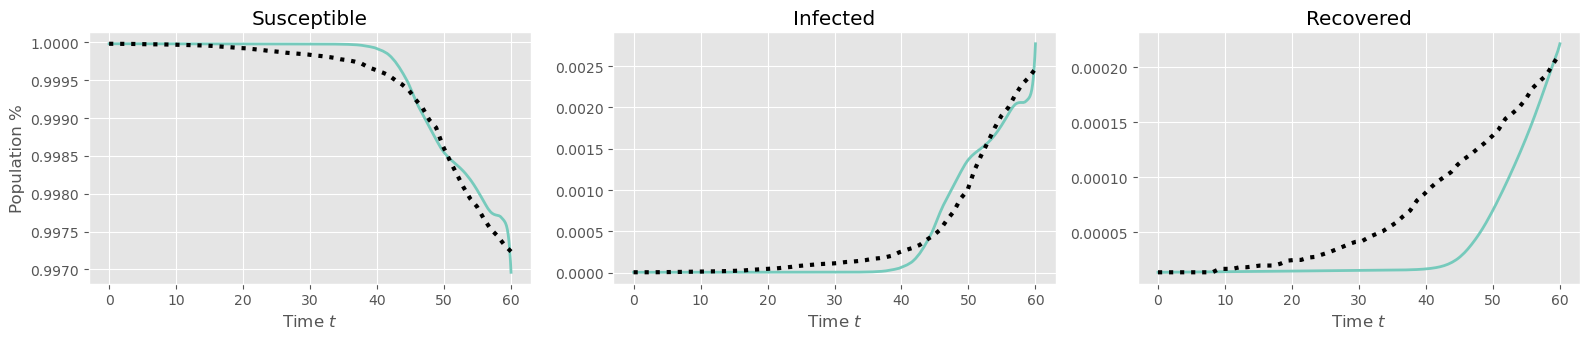

In [57]:
# Plot state 
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, ρ[0]/n, '-', c=colours_LMBFGS, linewidth=2)
ax[1].plot(Tₑ*7, ρ[1]/n, '-', c=colours_LMBFGS, linewidth=2)
ax[2].plot(Tₑ*7, ρ[2]/n, '-', c=colours_LMBFGS, linewidth=2)
    
# Add target
ax[0].plot(Tₑ*7, ρ̂[0]/n, ':', c='black', linewidth=3)
ax[1].plot(Tₑ*7, ρ̂[1]/n, ':', c='black', linewidth=3)
ax[2].plot(Tₑ*7, ρ̂[2]/n, ':', c='black', linewidth=3)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

In [58]:
obj_eval(ᾱ);

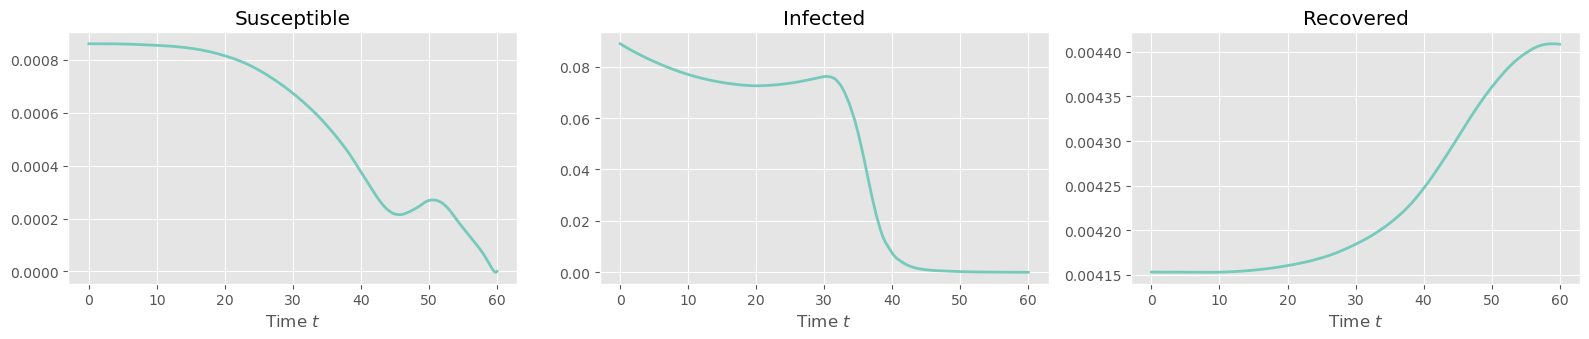

In [59]:
# Plot adjoint
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, q[0]/n, '-', c=colours_LMBFGS, linewidth=2)
ax[1].plot(Tₑ*7, q[1]/n, '-', c=colours_LMBFGS, linewidth=2)
ax[2].plot(Tₑ*7, q[2]/n, '-', c=colours_LMBFGS, linewidth=2)
    

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')



#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

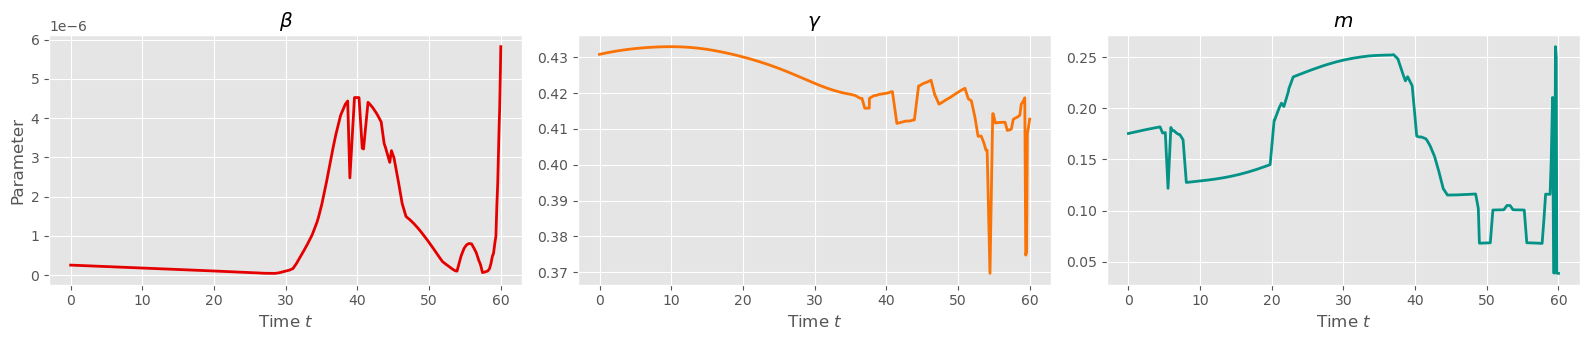

In [60]:
# Plot control 
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, ᾱ.data[0]*7*1e-4, '-', c='xkcd:red', linewidth=2)   #scale to original units
ax[1].plot(Tₑ*7, ᾱ.data[1]*7, '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, ᾱ.data[2]*7, '-', c='xkcd:teal', linewidth=2)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'$\beta$')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'$\gamma$')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'$m$')

ax[0].set_ylabel('Parameter')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

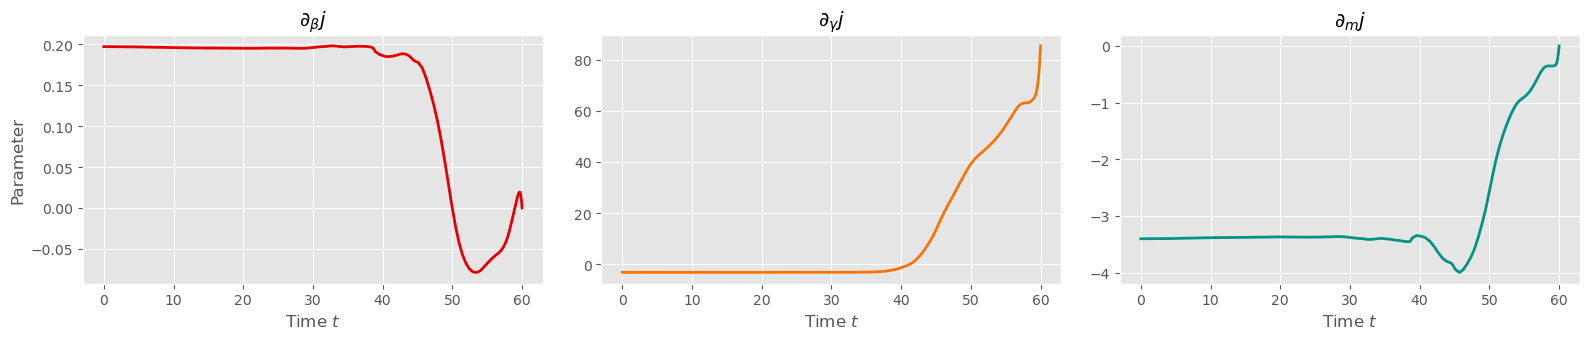

In [61]:
# Plot derivative 
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, best['df'][0]*7*1e-4, '-', c='xkcd:red', linewidth=2)
ax[1].plot(Tₑ*7, best['df'][1]*7, '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][2]*7, '-', c='xkcd:teal', linewidth=2)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'$\partial_\beta j$')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'$\partial_\gamma j$')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'$\partial_m j$')

ax[0].set_ylabel('Parameter')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

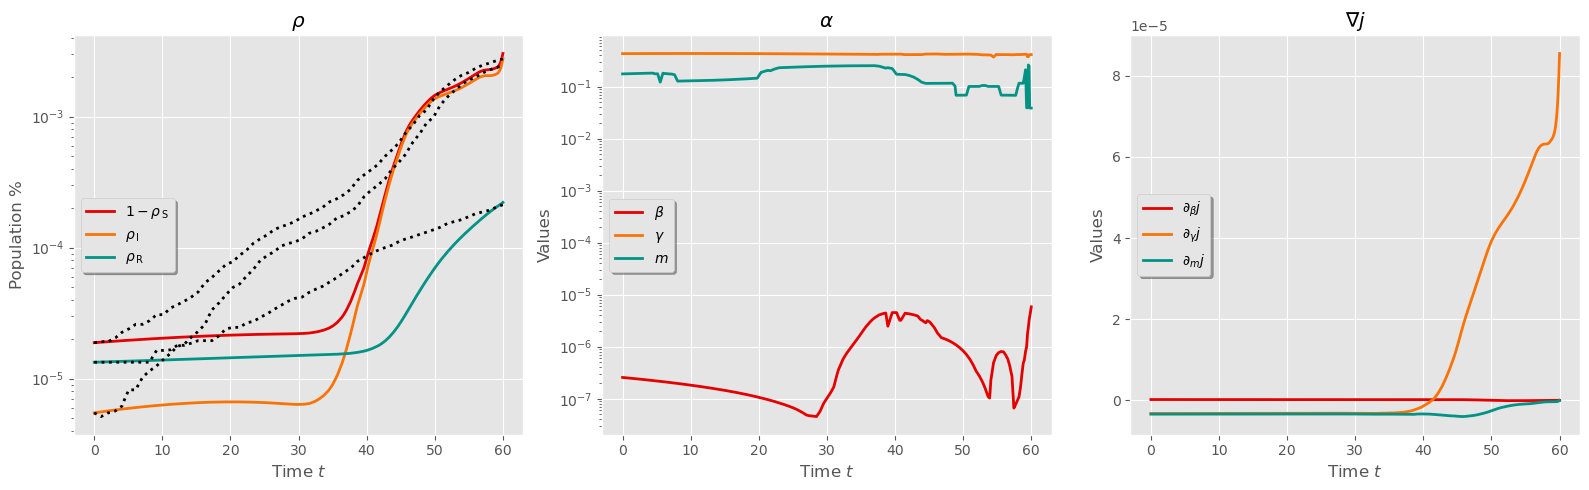

In [62]:
# Plot state 
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
colors = ['xkcd:red','xkcd:orange','xkcd:teal']

# Add state
ax[0].plot(Tₑ*7, 1 - ρ[0].T/n, '-', linewidth=2)
ax[0].plot(Tₑ*7, ρ[1:].T/n, '-', linewidth=2)
for i, line in enumerate(ax[0].get_lines()):    line.set_color(colors[i])
ax[0].legend(['$1-ρ_{\,\mathsf{S}}$', '$ρ_{\,\mathsf{I}}$', '$ρ_{\,\mathsf{R}}$'], shadow=True, loc='center left')

ax[0].plot(Tₑ*7, 1 - ρ̂[0].T/n, ':', c='black', linewidth=2)
ax[0].plot(Tₑ*7, ρ̂[1:].T/n, ':', c='black', linewidth=2)

ax[1].plot(Tₑ*7, ᾱ.data[0]*7*1e-4, '-', c='xkcd:red', linewidth=2)   #scale to original units
ax[1].plot(Tₑ*7, ᾱ.data[1]*7, '-', c='xkcd:orange', linewidth=2)
ax[1].plot(Tₑ*7, ᾱ.data[2]*7, '-', c='xkcd:teal', linewidth=2)
ax[1].legend(['$β$', '$γ$', '$m$'], shadow=True, loc='center left')

ax[2].plot(Tₑ*7, best['df'][0]*7*1e-4 / fact, '-', c='xkcd:red', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][1]*7 / fact, '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][2]*7 / fact, '-', c='xkcd:teal', linewidth=2)
ax[2].legend(['$\partial_β j$', '$\partial_γ j$', '$\partial_m j$'], shadow=True, loc='center left')


ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'$\rho$')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'$\alpha$')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'$\nabla j$')

ax[0].set_ylabel('Population %')
ax[1].set_ylabel('Values')
ax[2].set_ylabel('Values')

ax[0].set_yscale('log')#, linthresh=1e-2)
ax[1].set_yscale('log')
#ax[1].set_ylim([1e-8, 30*ᾱ.data[2].max()])

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Outputs/DD – Panels – LMBFGS.pdf', bbox_inches='tight', pad_inches=0)

In [63]:
(ᾱ.data[1]*7 + ᾱ.data[2]*7).max()

0.671418100408336

---

### Store

In [70]:
every_iter['obj'] = asarray(every_iter['obj'])
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
#df_every.to_pickle('Outputs/DD – nmAPG - Every.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,t_k,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0,55,1.960555e-07,15.50599,0.0,141.963399,383.97992,43373.63339,0.000078


In [75]:
# Should divide norms by scaling factor
383.97992/fact

0.00038397992

---

In [65]:
# Store best solution
np.savez_compressed('Outputs/DD – LMBFGS – Best', best = best)

In [66]:
#np.load('Outputs/DD – nmAPG – Best.npz', allow_pickle=True)['best']

---